# CNN Cancer detection report

## 1. Problem statement

This project delves into the exciting domain of medical image analysis, harnessing the power of Convolutional Neural Networks (CNNs) to address the pressing issue of cancer identification. We aim to create a robust binary image classification system capable of discerning between cancerous and non-cancerous tissue patches extracted from larger digital pathology scans.

In this project, we will explore the intricacies of CNNs, a class of deep learning models uniquely suited for image analysis tasks, and demonstrate their effectiveness in the context of medical image classification. By leveraging cutting-edge techniques in deep learning and utilizing a dataset comprising annotated pathology images, we endeavor to build a robust model capable of assisting pathologists in their crucial work.

The rest of this report will be structured as follows: we will delve into the methodology, data preprocessing, model architecture, training process, and evaluation metrics employed in the pursuit of our goal.

This project can be found on github - https://github.com/pramodhgopal/CNN-cancer-detection-model/tree/main

## 2. Important libraries and data

We have two datasets, a training and testing set already split for us. The training set contains 220,025 unique images and the test set contains 57,458, each represented in a .tif format. The dataset also contains a csv consisting of a 2-column table. First, there will be the ID of the test images and second the predicted label.Each label is either a 0 or 1, depending whether the image is non-cancerous (0) or cancerous (1). This dataset can be found on the Kaggle website - https://www.kaggle.com/competitions/histopathologic-cancer-detection/data .

First we will start with installing and important python libraries that will be used to create the CNN model in this report.

In [75]:
!pip install --upgrade pip
!pip install seaborn
!pip install plotly
!pip install scikit-image

In [76]:
import warnings
import string
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import random
from sklearn.utils import shuffle
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from skimage.transform import rotate
from skimage import io
from PIL import Image
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tifffile import imread
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout

The file path will vary depending on where the data was downloaded and the file structure. This is how my file structure is on my personal machine. The variables 'train_path' and 'test_path' represent the file path address to the images folders for the training set and testing set respectively. The 'train_data' variable is the main dataframe that contains the train_labels.csv file which houses the two columns mentioned above. Let us read in the csv files and see if we can read the data.

In [77]:
test_path = './input/histopathologic-cancer-detection/test/'
train_path = './input/histopathologic-cancer-detection/train/'

sample_submission = pd.read_csv('./input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('./input/histopathologic-cancer-detection/train_labels.csv')
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Here we can see that we are able to read in the csv file as a dataframe. Now, let us try to exploratory data analysis on the images as well as the dataframe. 

## 3. Exploratory Data Analysis

In this section, we will be doing some exploratory data analysis. Through this exploration, we aim to gain insights into the distribution of cancerous and non-cancerous patches, identify potential data imbalances, and uncover any data anomalies. By doing so, we can make informed decisions regarding data augmentation, model selection, and training strategies.

First let us verify the number of images in the training and testing folder respectively.

In [78]:
train_images = glob(train_path+'*.tif')
test_images = glob(test_path+'*.tif')

print(f'Total Training Images: {len(train_images)}')
print(f'Total Testing Images: {len(test_images)}')

Total Training Images: 220025
Total Testing Images: 57458


As we can see, the number images matches the data description. Let us try to display the images, so we can have a better idea of what we are dealing with. We will try to display the first 25 images in the training set folder.

In [79]:
img_train = os.listdir(train_path)
img_test = os.listdir(test_path)

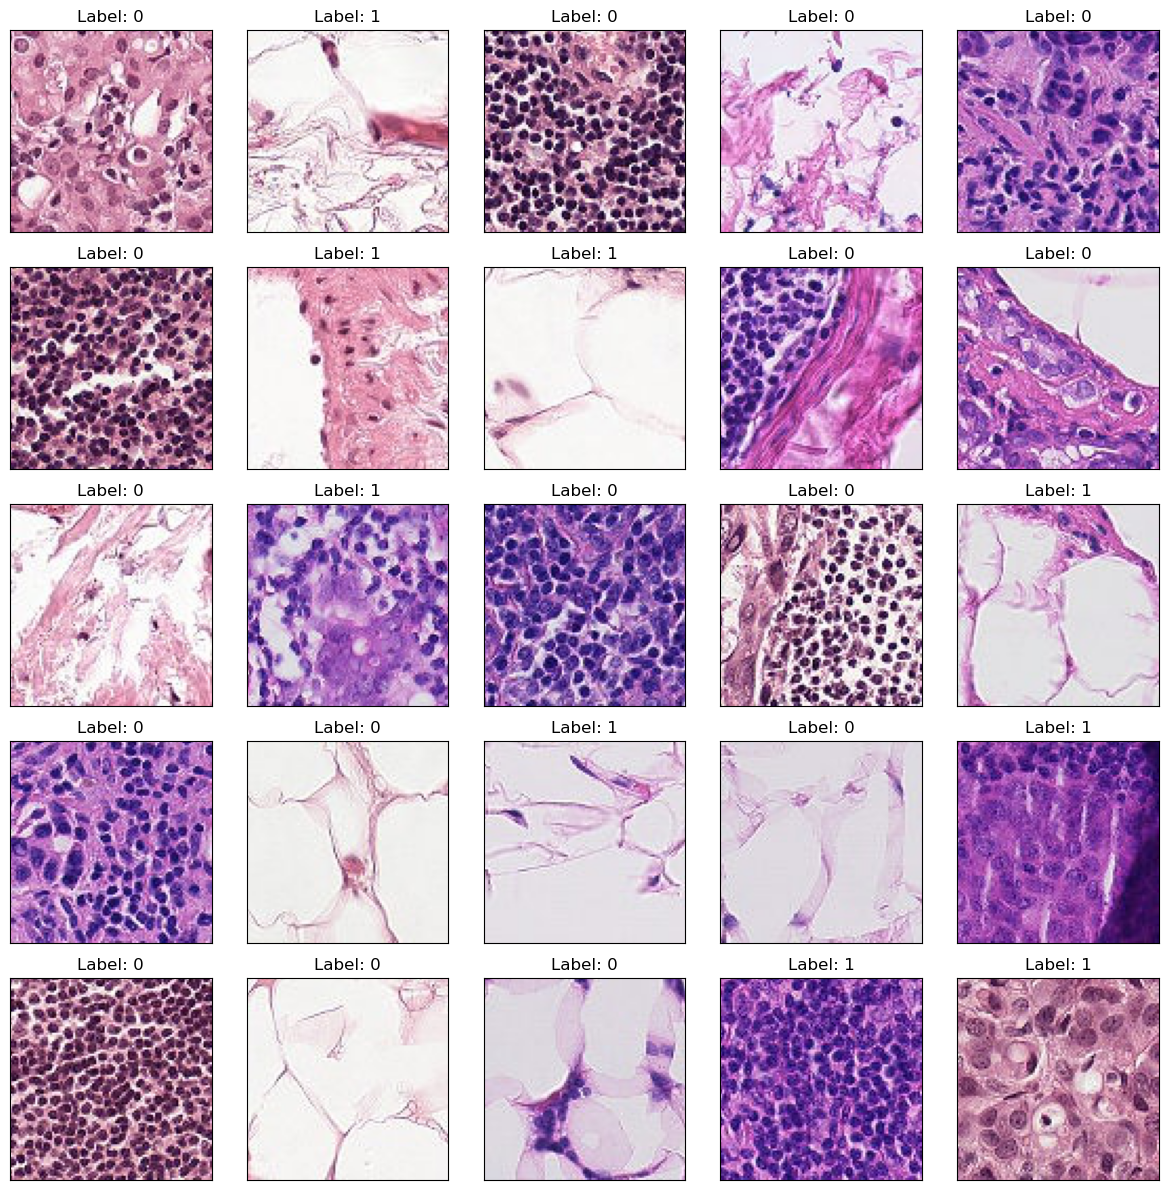

In [143]:
fig = plt.figure(figsize=(12, 12))
rows, cols = 5, 5

for i in range(25):
    ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    im = Image.open(train_path + img_train[i])
    plt.imshow(im)
    label = train_data.loc[i, 'label']
    ax.set_title(f'Label: {label}')

plt.tight_layout()
plt.show()

Now that we have an idea of what the images look like, let us take a look at the number of images that is labelled as cancerous versus the ones that are not. The aim here is identify if the data is skewed towards a particular label.

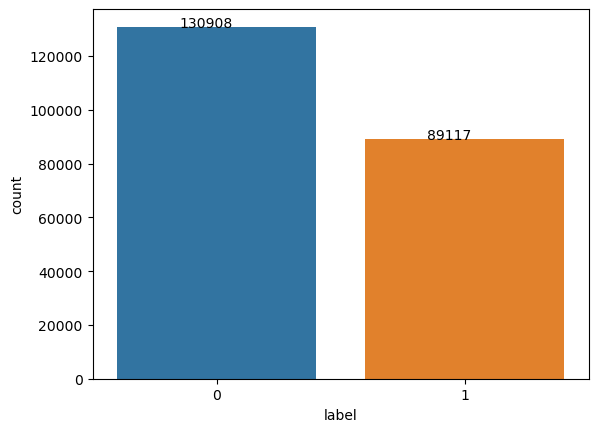

In [81]:
ax = sns.countplot(data = train_data, x='label')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+10))

As we can see, the data is imbalanced. There are 130908 images that are labeled 0 (non-cancerous) as opposed to 89117 that are labeled 1 (cancerous). Using the current data as it is to train our model might make it a bit biased and thus, we would have a model that cannot predict cancer in a reliable way. We will need to balance this dataset so that it doesn't affect our model and we can simply use the resampling method.

### 3.1 Data balancing

In order to balance the dataset, we will pick a sample size of 30000 and pull in equal amounts of random images labelled 0 and 1 and store them in a temporary dataframe. That means this dataframe will have 60000 entries of images, half will be labelled as non-cancerous and the other half will be labelled as cancerous. We will also shuffle the dataset to ensure our model's accuracy.

In [82]:
# sample 30000 positive and negative images and split them evenly
sample_size = 30000
train_negative = train_data[train_data['label'] == 0].sample(sample_size, random_state=42)
train_positive = train_data[train_data['label'] == 1].sample(sample_size, random_state=42)

# create a new shuffeled training dataset
train_data_sample = shuffle(pd.concat([train_positive, train_negative], axis=0).reset_index(drop=True))
train_data_sample.head()

,id,label
20689,4ccd615797f94e7e887d15b904655ead1a5fb94e,1
16385,8d89de5f2ee0acb9d11c3fdbc433cd562e6c7eac,1
3279,a3143e033179f91f3cc832a452e2c7e27c6365ea,1
48824,2e0c1b9339e4b4bd26fd5d0e4ae90ba425b34119,0
39147,bd4b3d7236f234145b44bfbfc69284de7f6138c0,0


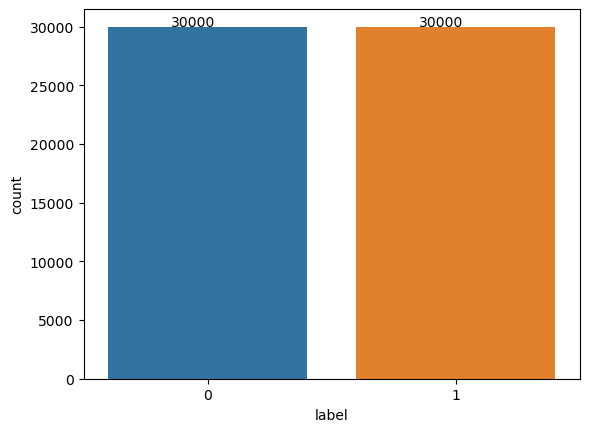

In [83]:
ax = sns.countplot(data = train_data_sample, x='label')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+10))

As we can see, the resulting dataset is now balanced and contains a total of 60,000 images. We stored this dataset in a new dataframe which we will use for model building and training. 

## 4. Model Architecture

The architecture of the first model is structured as follows:

Input -> Convolutional Layer -> Convolutional Layer -> Max-Pooling Layer -> Convolutional Layer -> Convolutional Layer -> Max-Pooling Layer -> Flatten -> Dense -> Dense -> Output

For the activation functions in the hidden layers, I'll utilize ReLU (Rectified Linear Unit) to introduce non-linearity and capture important features within the data. The dense layers, situated before the output layer, will employ a combination of ReLU and sigmoid activations to extract complex patterns and produce the final binary classification output.
This model will be run as is without finetuning any hyperparameters.

We will employ substantial batch sizes, specifically set to 256, aimed at mitigating variance during training. Additionally, our model will undergo 10 training epochs. To gauge model performance, we will assess accuracy and evaluate the validation-loss accuracy. Moreover, binary cross-entropy will serve as our chosen loss function throughout the training process.

The code snippet below attempts to configure and utilize a TPU for distributed training if one is available, and if not, it defaults to the standard hardware available. After that is done, we will initialize our model and use our balanced dataset dataframe (train_data_sample) to train our model.

### 4.1 Model 1

In [84]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [85]:
ROC_model = tf.keras.metrics.AUC()

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model.build(input_shape=(batch_size, 64, 64, 3))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (256, 62, 62, 16)         448       
                                                                 
 conv2d_17 (Conv2D)          (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (256, 30, 30, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (256, 28, 28, 32)         4640      
                                                                 
 conv2d_19 (Conv2D)          (256, 26, 26, 32)         9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (256, 13, 13, 32)         0         
 g2D)                                                 

In [86]:
print(train_data_sample['label'].value_counts())

1    30000
0    30000
Name: label, dtype: int64


Using balanced dataset to generate training and testing data.

In [87]:
# Generate training and validation data

RANDOM_STATE = 49
BATCH_SIZE = 256

def append_tif(string):
    return string+".tif"

train_data_sample["id"] = train_data_sample["id"].apply(append_tif)
train_data_sample['label'] = train_data_sample['label'].astype(str)

# randomly shuffle training data
train_data_sample = shuffle(train_data_sample, random_state=RANDOM_STATE)

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data_sample,
    
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data_sample,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

Found 51000 validated image filenames belonging to 2 classes.
Found 9000 validated image filenames belonging to 2 classes.


 We will set our learning rate to 0.0001 and compile our model.

In [89]:
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
sig_model = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
200/200 [==============================] - 426s 2s/step - loss: 0.5981 - accuracy: 0.6943 - val_loss: 0.4988 - val_accuracy: 0.7647
Epoch 2/10
200/200 [==============================] - 69s 345ms/step - loss: 0.4798 - accuracy: 0.7784 - val_loss: 0.4874 - val_accuracy: 0.7718
Epoch 3/10
200/200 [==============================] - 69s 342ms/step - loss: 0.4722 - accuracy: 0.7827 - val_loss: 0.4790 - val_accuracy: 0.7756
Epoch 4/10
200/200 [==============================] - 68s 340ms/step - loss: 0.4651 - accuracy: 0.7867 - val_loss: 0.4738 - val_accuracy: 0.7768
Epoch 5/10
200/200 [==============================] - 69s 343ms/step - loss: 0.4589 - accuracy: 0.7895 - val_loss: 0.4659 - val_accuracy: 0.7796
Epoch 6/10
200/200 [==============================] - 69s 343ms/step - loss: 0.4528 - accuracy: 0.7920 - val_loss: 0.4624 - val_accuracy: 0.7821
Epoch 7/10
200/200 [==============================] - 69s 346ms/step - loss: 0.4462 - accuracy: 0.7953 - val_loss: 0.4520 - val_accu

### 4.1.1 Evaluating the first model and analysis

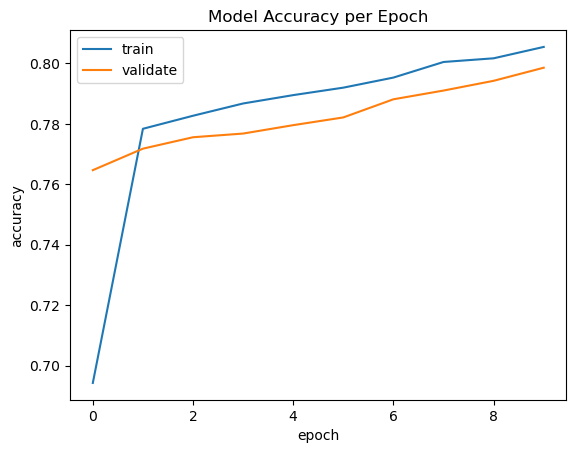

In [96]:
plt.plot(sig_model.history['accuracy'])
plt.plot(sig_model.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc = 'upper left')
plt.show()

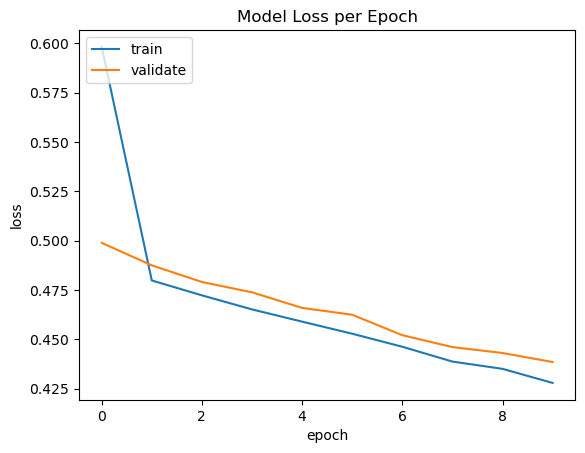

In [99]:
plt.plot(sig_model.history['loss'])
plt.plot(sig_model.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

The slopes are very consistent, and the accuracy converges with the validation accuracy, which is a good sign.

The model looks like an ok fit overall, and the final training accuracy was accuracy: 0.8054, and validation accuracy was val_accuracy: 0.7986. Let us see if we can make it better with another model.

### 4.2 Model 2

This model's architecture will be as follows:
Input -> Convolutional Layer -> Convolutional Layer -> Max-Pooling Layer -> Convolutional Layer -> Convolutional Layer -> Max-Pooling Layer -> Flatten -> Dense -> Dropout -> Dense -> Output

This model hosts a deeper architecture, featuring two additional pairs of convolutional layers that facilitate the extraction of intricate and hierarchical features within the dataset. Additionally, dropout layers are introduced to mitigate overfitting by randomly deactivating neurons during training, enhancing the model's ability to generalize. The inclusion of extra dense layers, with 128 and 64 units respectively, before the final output layer further augments its capacity to learn complex patterns.

In [100]:
new_model = Sequential()

# Convolutional Layers
new_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
new_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))

new_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
new_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
new_model.add(Flatten())

# Dense Layers
new_model.add(Dense(units=128, activation='relu'))
new_model.add(Dropout(0.5))  # Adding dropout for regularization
new_model.add(Dense(units=64, activation='relu'))
new_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [101]:
sig_model2 = new_model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
200/200 [==============================] - 148s 734ms/step - loss: 0.5064 - accuracy: 0.7585 - val_loss: 0.4749 - val_accuracy: 0.7783
Epoch 2/10
200/200 [==============================] - 147s 733ms/step - loss: 0.4554 - accuracy: 0.7937 - val_loss: 0.4762 - val_accuracy: 0.7829
Epoch 3/10
200/200 [==============================] - 146s 728ms/step - loss: 0.4249 - accuracy: 0.8086 - val_loss: 0.4168 - val_accuracy: 0.8103
Epoch 4/10
200/200 [==============================] - 145s 722ms/step - loss: 0.4121 - accuracy: 0.8153 - val_loss: 0.4089 - val_accuracy: 0.8160
Epoch 5/10
200/200 [==============================] - 144s 722ms/step - loss: 0.3807 - accuracy: 0.8319 - val_loss: 0.3684 - val_accuracy: 0.8351
Epoch 6/10
200/200 [==============================] - 146s 728ms/step - loss: 0.3583 - accuracy: 0.8435 - val_loss: 0.3751 - val_accuracy: 0.8352
Epoch 7/10
200/200 [==============================] - 145s 724ms/step - loss: 0.3393 - accuracy: 0.8522 - val_loss: 0.3541 -

### 4.2.1 Evaluating the new model and analysis

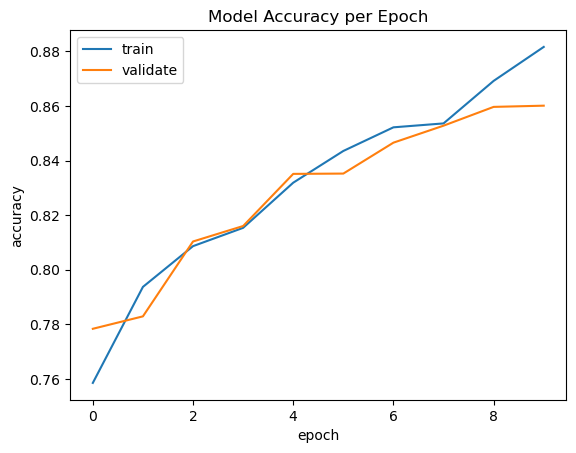

In [102]:
plt.plot(sig_model2.history['accuracy'])
plt.plot(sig_model2.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc = 'upper left')
plt.show()

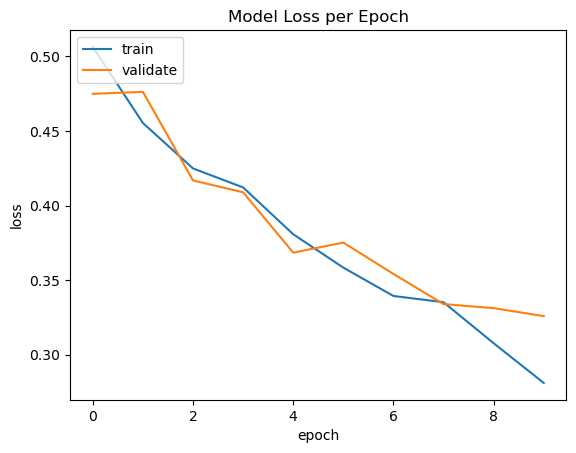

In [103]:
plt.plot(sig_model2.history['loss'])
plt.plot(sig_model2.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

This modified model exhibits improved accuracy over the original model across the training epochs. Starting with an accuracy of approximately 0.76 in the initial epoch, it progressively improves to reach an accuracy of around 0.88 by the final epoch. In contrast, the original model's accuracy started at approximately 0.69 and increased to around 0.80 by the end of its training. This indicates that the modified model, with its additional layers and dropout regularization, is more effective in learning and capturing complex patterns in the dataset, resulting in a higher accuracy when compared to the original model.

### Using our model to predict on the test data

In [104]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [112]:
image_test_df = pd.DataFrame({'id':os.listdir(test_path)})
image_test_df.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [113]:
# prepare test data (in same way as train data)
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=image_test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [114]:
predictions = new_model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 195s 3ms/step


In [115]:
pred = np.transpose(predictions)[0]

predicted_df = pd.DataFrame()
predicted_df['id'] = image_test_df['id'].apply(lambda x: x.split('.')[0])
predicted_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))

In [116]:
predicted_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [117]:
predicted_df.to_csv('submission.csv', index=False)

## 5. Conclusion

In conclusion, our evaluation of the two distinct CNN models for the task of detecting cancer from image patches reveals noteworthy differences in their performance. The original model, while capable, demonstrated an accuracy of approximately 0.80 after ten training epochs, showcasing its ability to discern cancerous from non-cancerous patches. However, the modified model, characterized by an expanded architecture with additional convolutional and dense layers, as well as dropout regularization, displayed superior performance. With a training accuracy that escalated from approximately 0.76 to 0.88 over the same ten epochs, it demonstrated a significant edge in capturing intricate patterns within the dataset. This outcome underscores the importance of model complexity and regularization techniques in improving predictive accuracy. Further fine-tuning and experimentation may be beneficial, but these results highlight the potential of the modified model as the superior candidate for accurate cancer detection using digital images.

As mentioned, this project can be found in https://github.com/pramodhgopal/CNN-cancer-detection-model/tree/main